## Aprendizaje Profundo: Tarea 1 - Ejercicio 4
### Samuel López Ruiz
---
Implementación de una red completamente conectada para la tarea de clasificación de imágenes sobre
el conjunto de Fashion-MNIST.

Importación de librerías

In [5]:
import random
import time
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import islice as take
import tensorflow as tf
import tensorboard as tb
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import seaborn as sns
sns.set_theme()
sns.set_context("poster")

activations = {'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh()}


Definición de una red completamente conectada así
como una red convolucional para usar como referencia

In [2]:
class DenseNet(nn.Module):
    def __init__(self, n_hidden_layers, n_nodes, activation='relu'):
        super().__init__()
        self.activation = activation
        self.image_flatten_dim = 1 * 28 * 28
        self.flatten = nn.Flatten()
        self.in_layer = nn.Linear(in_features=self.image_flatten_dim, out_features=n_nodes)
        self.fcs = [nn.Linear(in_features=n_nodes, out_features=n_nodes) for i in range(n_hidden_layers - 1)]
        self.out_layer = nn.Linear(in_features=n_nodes, out_features=10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.in_layer(x)
        for layer in self.fcs:
            x = activations[self.activation](layer(x))
        x = self.out_layer(x)
        return x


class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Funciones para entrenar y evaluar los modelos


In [14]:
def train_epoch(dataloader, model, optimizer, criterion):
    # por cada lote
    for inputs, labels in dataloader:
        # computamos logits
        outputs = model(inputs)

        # computamos la pérdida
        loss = criterion(outputs, labels)

        # vaciamos los gradientes
        optimizer.zero_grad()

        # retropropagamos
        loss.backward()

        # actualizamos parámetros
        optimizer.step()


def eval_epoch(dataloader, model, criterion, num_batches=None):
    # evitamos que se registren las operaciones
    # en la gráfica de cómputo
    with torch.no_grad():
        # historiales
        losses = []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for inputs, labels in take(dataloader, num_batches):
            # computamos los logits
            outputs = model(inputs)

            # computamos la pérdida
            loss = criterion(outputs, labels)

            # guardamos históricos
            losses.append(loss.item())

        # promediamos
        loss = np.mean(losses)

        return loss


def train(model, optimizer, train_dl, test_dl, criterion, epochs=20,
          trn_batches=None, tst_batches=None, verbose=2):
    # historiales
    loss_hist = []

    # ciclo de entrenamiento
    for epoch in range(epochs):
        # entrenamos la época
        train_epoch(train_dl, model, optimizer, criterion)

        # evaluamos la época en entrenamiento
        trn_loss = eval_epoch(train_dl, model, criterion, trn_batches)
        # evaluamos la época en prueba
        tst_loss = eval_epoch(test_dl, model, criterion, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])

        # imprimimos progreso
        if verbose > 1:
            print(f' E{epoch:02} '
                  f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] ')

    return np.array(loss_hist)


def plot_loss_hist(loss_hist, title=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(loss_hist[:, 0], label='Train Loss')
    ax.plot(loss_hist[:, 1], label='Test Loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch')
    plt.xlabel('loss')
    plt.tight_layout()
    plt.show()


def train_test_model(model_cfg, plot_=False, verbose=2, model_arch='Dense'):
    if model_arch == 'Dense':
        model = DenseNet(n_hidden_layers=model_cfg['n_hidden_layers'], n_nodes=model_cfg['n_nodes'],
                         activation=model_cfg['activation'])
    else:
        model = CnnNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=model_cfg['learning_rate'], momentum=0.9)
    t0 = time.time()
    loss_hist = train(model, optimizer, trainloader, testloader, criterion,
                      epochs=model_cfg['n_epochs'], verbose=verbose)
    if verbose > 0:
        print('Train Time: {} s'.format(round(time.time() - t0, 4)))
        print('Test Loss: {}'.format(round(loss_hist[-1][-1], 2)))
    if plot_:
        plot_loss_hist(loss_hist, str(model_cfg))
    return model, loss_hist


def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Funciones para crear la gráfica de precisión-recall usando las probabilidades
emitidas por el modelo clasificador.


In [12]:
def calc_probs(dataloader, model):
    class_probs = []
    class_label = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            output = model(images)
            class_probs_batch = [F.softmax(el, dim=0) for el in output]

            class_probs.append(class_probs_batch)
            class_label.append(labels)

    test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
    test_label = torch.cat(class_label)

    return test_probs, test_label


def compute_curve(labels, predictions, num_thresholds=127, weights=None):
    _MINIMUM_COUNT = 1e-7

    if weights is None:
        weights = 1.0

    # Compute bins of true positives and false positives.
    bucket_indices = np.int32(np.floor(predictions * (num_thresholds - 1)))
    float_labels = labels.astype(np.float64)
    histogram_range = (0, num_thresholds - 1)
    tp_buckets, _ = np.histogram(
        bucket_indices,
        bins=num_thresholds,
        range=histogram_range,
        weights=float_labels * weights)
    fp_buckets, _ = np.histogram(
        bucket_indices,
        bins=num_thresholds,
        range=histogram_range,
        weights=(1.0 - float_labels) * weights)

    # Obtain the reverse cumulative sum.
    tp = np.cumsum(tp_buckets[::-1])[::-1]
    fp = np.cumsum(fp_buckets[::-1])[::-1]
    tn = fp[0] - fp
    fn = tp[0] - tp
    precision = tp / np.maximum(_MINIMUM_COUNT, tp + fp)
    recall = tp / np.maximum(_MINIMUM_COUNT, tp + fn)
    return np.stack((tp, fp, tn, fn, precision, recall))


def make_np(x):
    if isinstance(x, np.ndarray):
        return x
    if np.isscalar(x):
        return np.array([x])
    if isinstance(x, torch.Tensor):
        if isinstance(x, torch.autograd.Variable):
            x = x.data
        x = x.cpu().numpy()
        return x
    raise NotImplementedError(
        'Got {}, but numpy array, torch tensor, or caffe2 blob name are expected.'.format(type(x)))


def pr_curve(class_index, test_probs, test_label):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]
    return compute_curve(make_np(tensorboard_truth), make_np(tensorboard_probs))


def plot_pr_curves(n_classes, test_probs, test_label):
    fig, axes = plt.subplots(2, 5, figsize=(20, 15))
    for i in range(n_classes):
        curve = pr_curve(i, test_probs, test_label)
        axes[i % 2][i // 2].plot(curve[4, :-1], curve[5, :-1])
        axes[i % 2][i // 2].title.set_text('Class = {}'.format(i))
        axes[i % 2][i // 2].set_xlabel('recall')
        axes[i % 2][i // 2].set_ylabel('precision')
    plt.suptitle('Precision-Recall Curves')
    plt.tight_layout()
    plt.show()

Declaración de semillas para garantizar reproducibilidad.
Descarga del set de datos.

In [6]:
if 'data' not in os.listdir('.'):
        os.mkdir('./data')
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# datasets and dataloaders
trainset = FashionMNIST('./data', download=True, train=True, transform=transform)
testset = FashionMNIST('./data', download=True, train=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



C:\Users\sam24\.conda\envs\machine_learning\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Visualización del primer lote de imagenes.

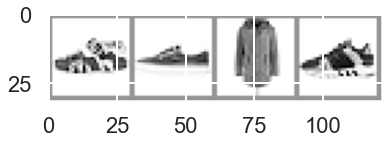

In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid and show images
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

Entrenamiento y evaluación de una red completamente conectada.
En la gráfica de precisión-recall (PR) podemos ver que las clases 4 y 6 tienen la menor área sobre la curva (AUC),
mientras que las clases 5, 7, y 9 tienen la mayor AUC.
La pérdida final en los datos de prueba fue de: 0.37

 E00 loss=[  0.51,  0.54] 
 E01 loss=[  0.44,  0.48] 
 E02 loss=[  0.40,  0.44] 
 E03 loss=[  0.39,  0.43] 
 E04 loss=[  0.37,  0.41] 
 E05 loss=[  0.38,  0.43] 
 E06 loss=[  0.35,  0.40] 
 E07 loss=[  0.35,  0.40] 
 E08 loss=[  0.34,  0.40] 
 E09 loss=[  0.33,  0.39] 
 E10 loss=[  0.32,  0.38] 
 E11 loss=[  0.32,  0.38] 
 E12 loss=[  0.31,  0.37] 
 E13 loss=[  0.30,  0.37] 
 E14 loss=[  0.30,  0.37] 
 E15 loss=[  0.30,  0.37] 
 E16 loss=[  0.29,  0.36] 
 E17 loss=[  0.28,  0.35] 
 E18 loss=[  0.29,  0.36] 
 E19 loss=[  0.29,  0.37] 
Train Time: 532.9783 s
Test Loss: 0.37


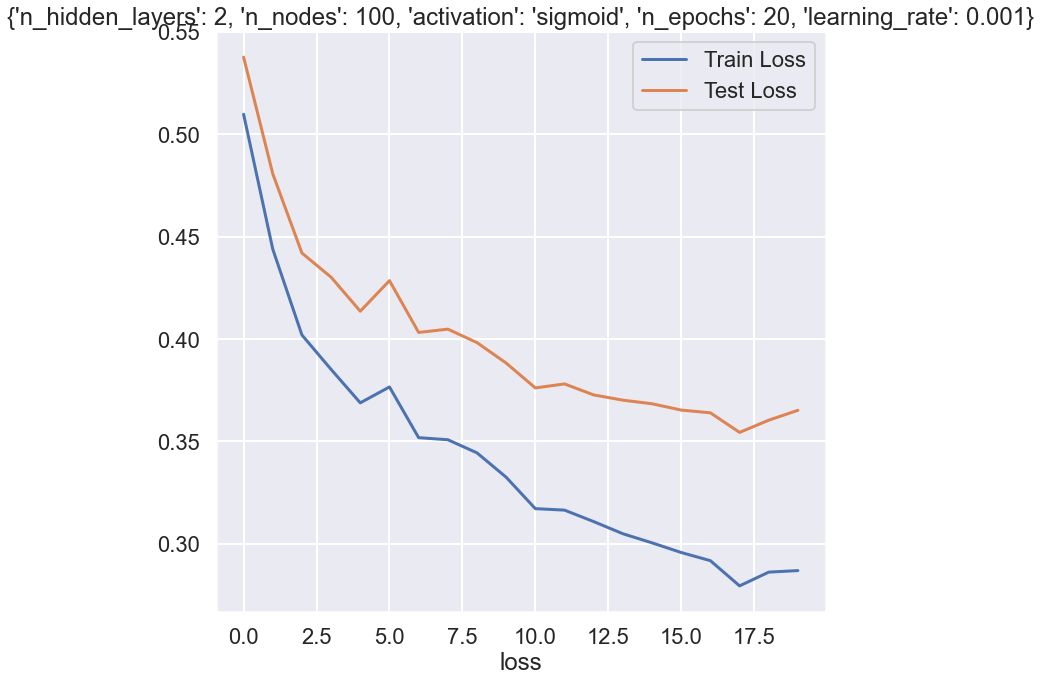

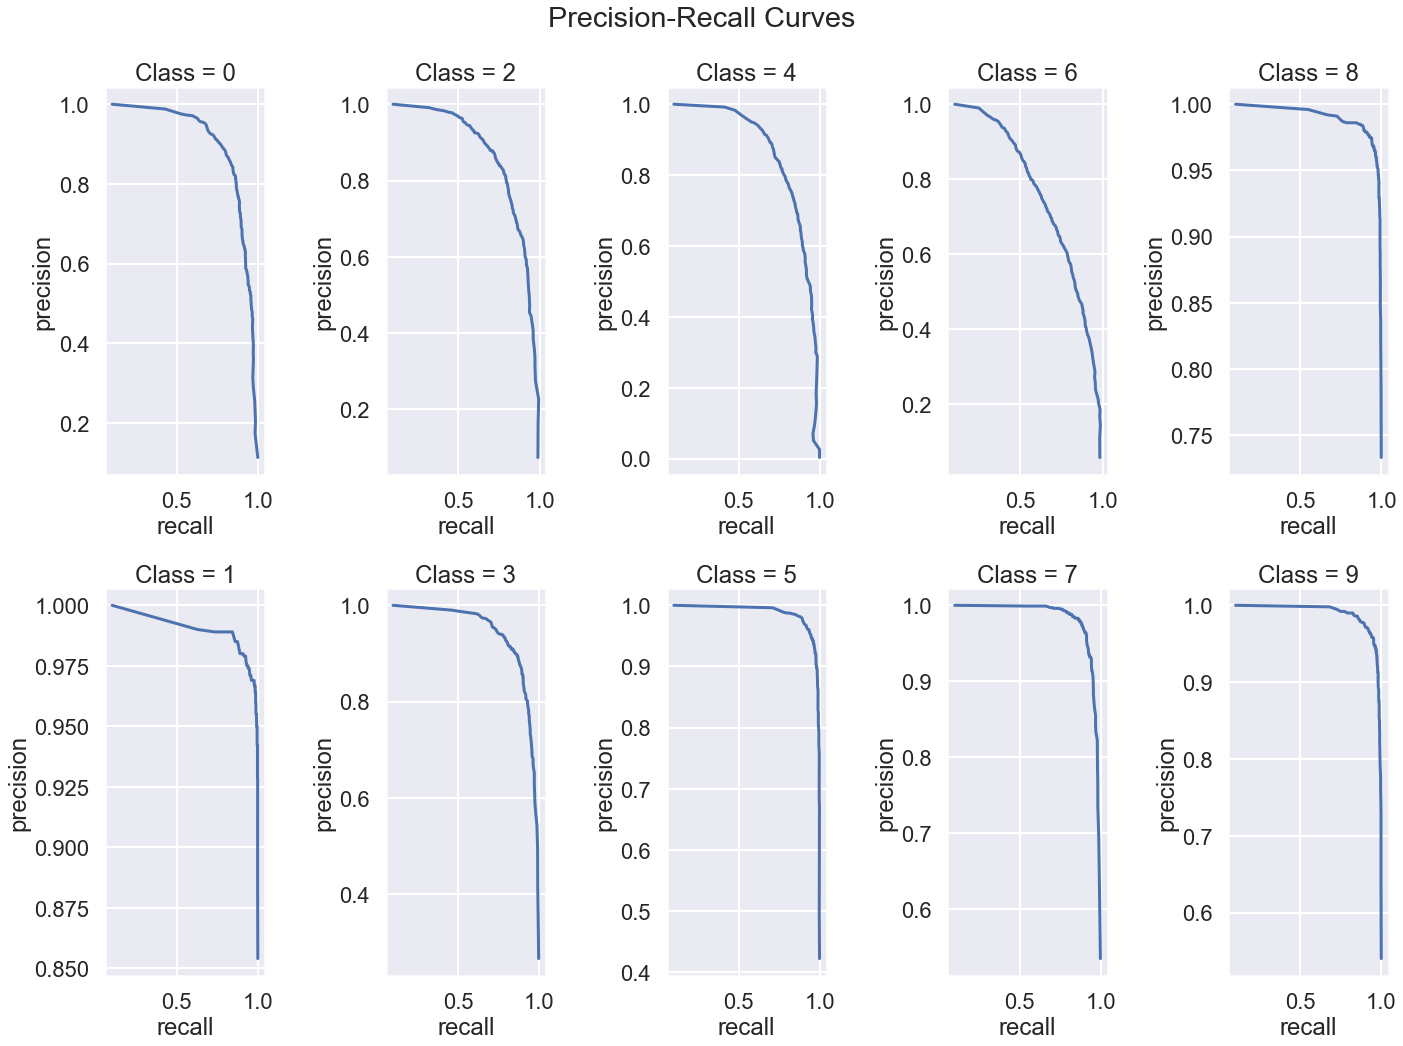

In [16]:
model_cfg = {'n_hidden_layers': 2, 'n_nodes': 100, 'activation': 'sigmoid',
            'n_epochs': 20, 'learning_rate': 0.001}
model, loss_hist = train_test_model(model_cfg, plot_=True)

# obtenemos la probabilidad de las predicciones en un tensor de: test_size x num_classes
test_probs, test_label = calc_probs(testloader, model)

# graficamos todas las curvas de precisión-recall
plot_pr_curves(len(classes), test_probs, test_label)

Ahora reducimos el número de capas ocultas a 1 capa e incrementamos el número de nodos por capa a 200.
Podemos observar en la gráfica de las pérdidas que el modelo no es capaz de aprender a lo largo
de las épocas y al final la pérdida final es de 0.48.

 E00 loss=[  0.48,  0.51] 
 E01 loss=[  0.43,  0.47] 
 E02 loss=[  0.42,  0.47] 
 E03 loss=[  0.42,  0.47] 
 E04 loss=[  0.45,  0.51] 
 E05 loss=[  0.42,  0.48] 
 E06 loss=[  0.41,  0.47] 
 E07 loss=[  0.41,  0.47] 
 E08 loss=[  0.40,  0.47] 
 E09 loss=[  0.43,  0.49] 
 E10 loss=[  0.44,  0.51] 
 E11 loss=[  0.40,  0.47] 
 E12 loss=[  0.40,  0.47] 
 E13 loss=[  0.39,  0.46] 
 E14 loss=[  0.38,  0.45] 
 E15 loss=[  0.38,  0.46] 
 E16 loss=[  0.39,  0.47] 
 E17 loss=[  0.41,  0.49] 
 E18 loss=[  0.40,  0.49] 
 E19 loss=[  0.39,  0.48] 
Train Time: 516.8261 s
Test Loss: 0.48


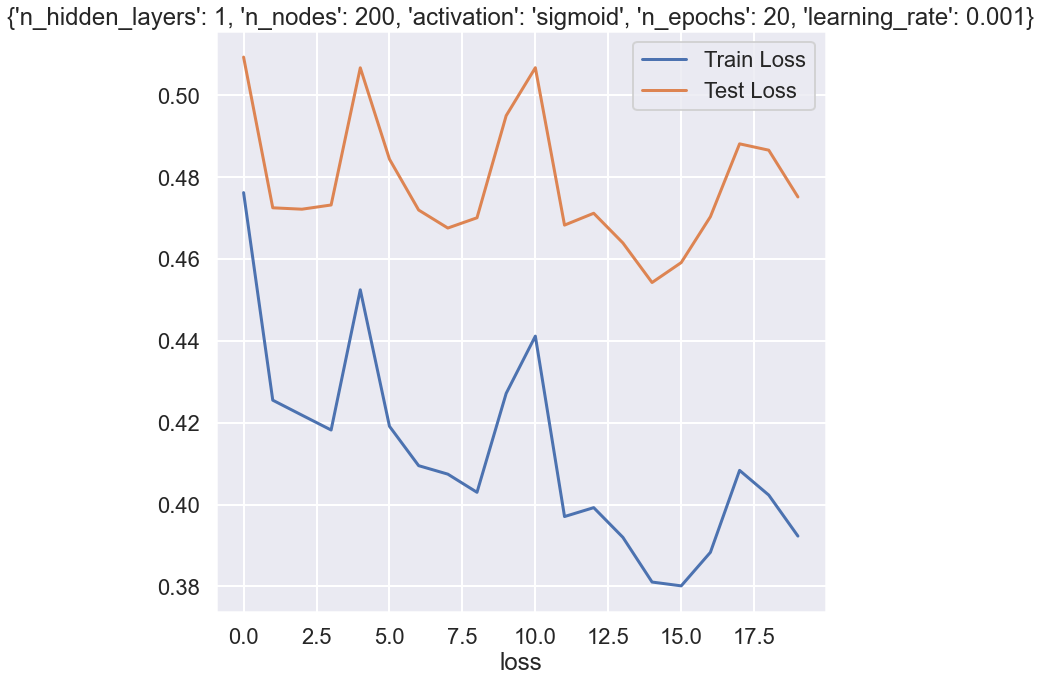

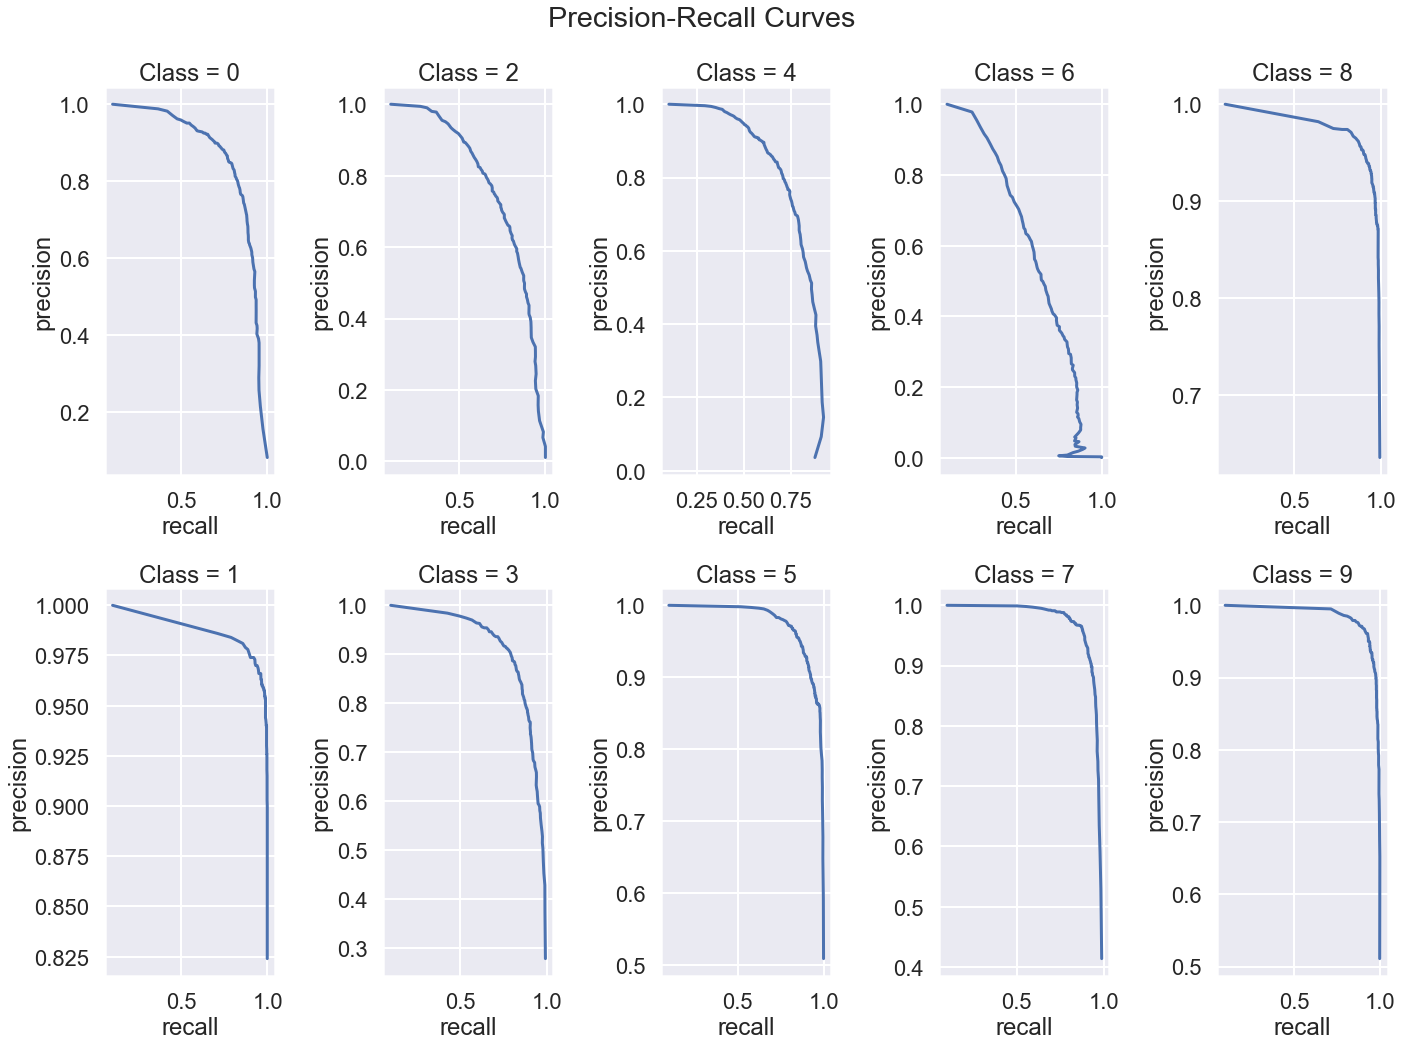

In [22]:
model_cfg = {'n_hidden_layers': 1, 'n_nodes': 200, 'activation': 'sigmoid',
             'n_epochs': 20, 'learning_rate': 0.001}
model, loss_hist = train_test_model(model_cfg, plot_=True)

# obtenemos la probabilidad de las predicciones en un tensor de: test_size x num_classes
test_probs, test_label = calc_probs(testloader, model)

# graficamos todas las curvas de precisión-recall
plot_pr_curves(len(classes), test_probs, test_label)

Como un último experimento, incrementamos el número de capas ocultas a 3 y cambiamos las funciones de
activación a 'relu'. La pérdida total es de 0.38 y es muy similar a cuando usamos 2 capas y la función
de activación 'sigmoide'. <br>
También observamos que desde la época 6, el model pareciera no mejorar en desempeño, lo cual
puede ser un indicador de tener desvanecimiento de gradiente.

 E00 loss=[  0.42,  0.46] 
 E01 loss=[  0.39,  0.43] 
 E02 loss=[  0.35,  0.40] 
 E03 loss=[  0.33,  0.39] 
 E04 loss=[  0.31,  0.37] 
 E05 loss=[  0.33,  0.39] 
 E06 loss=[  0.31,  0.38] 
 E07 loss=[  0.30,  0.38] 
Train Time: 226.0656 s
Test Loss: 0.38


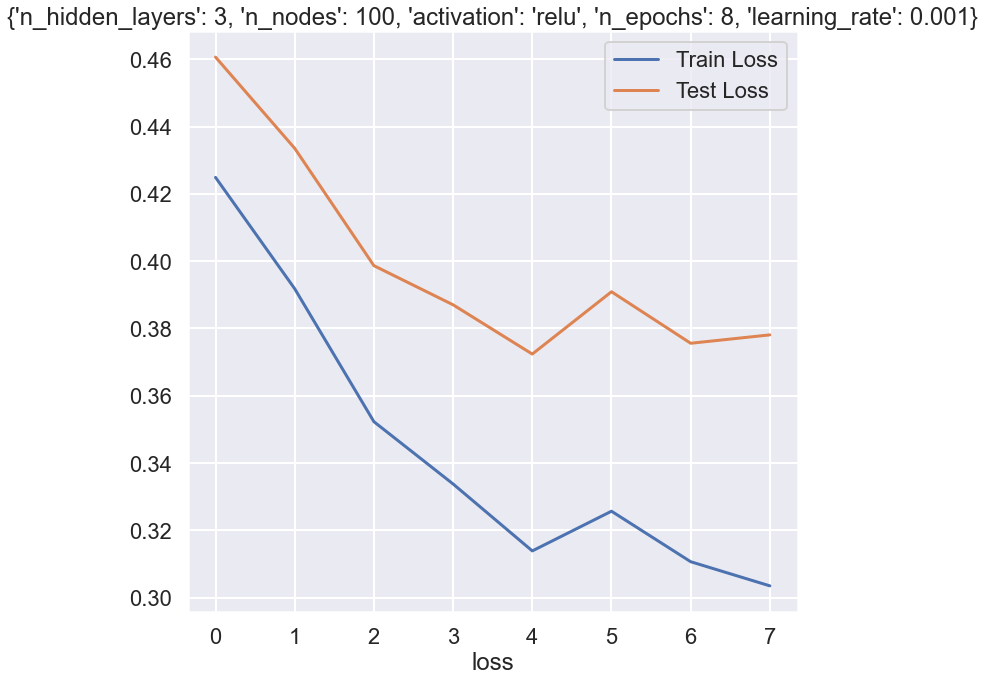

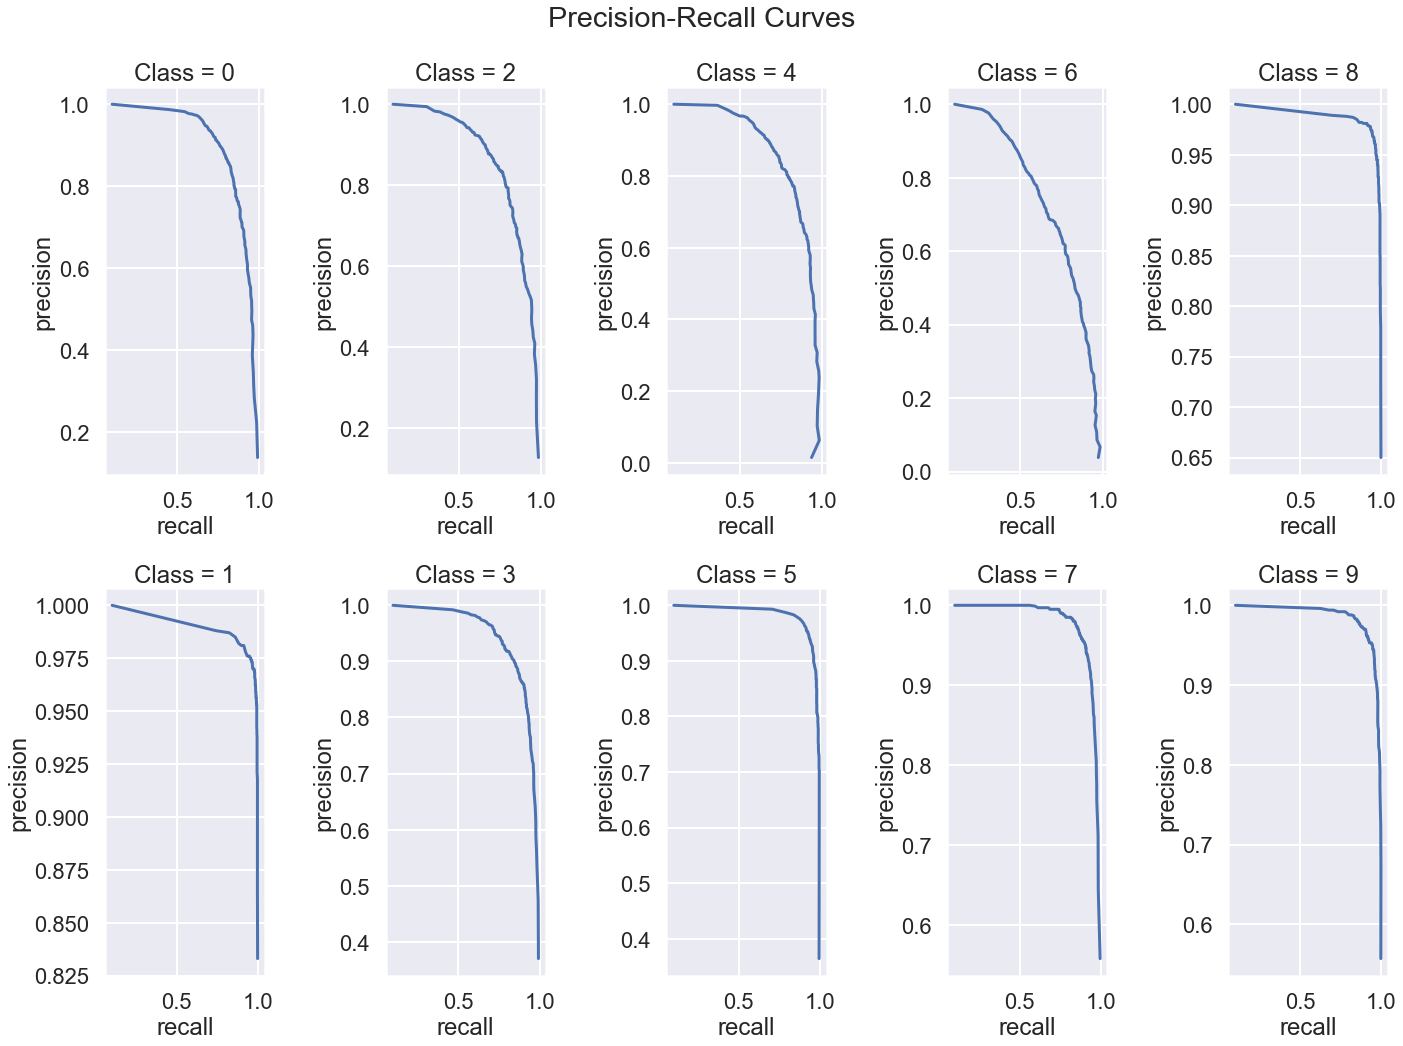

In [20]:
model_cfg = {'n_hidden_layers': 3, 'n_nodes': 100, 'activation': 'relu',
             'n_epochs': 20, 'learning_rate': 0.001}
model, loss_hist = train_test_model(model_cfg, plot_=True, verbose=2)

# obtenemos la probabilidad de las predicciones en un tensor de: test_size x num_classes
test_probs, test_label = calc_probs(testloader, model)

# graficamos todas las curvas de precisión-recall
plot_pr_curves(len(classes), test_probs, test_label)

A modo de comparación con la arquitectura predilecta para procesamiento de imágenes, vamos a
entrenar y evaluar una red neuronal convolucional (CNN). Podemos observar que el tiempo de
entrenamiento es menor y de igual forma la périda después de 15 epocas es de: 0.31
También podemos notar que el modelo empieza a sobre ajustar los datos antes que las redes densas, i.e.
desde la época 17 a comparación de ~8 para redes densas.

C:\Users\sam24\.conda\envs\machine_learning\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 E00 loss=[  0.41,  0.44] 
 E01 loss=[  0.32,  0.35] 
 E02 loss=[  0.32,  0.36] 
 E03 loss=[  0.27,  0.34] 
 E04 loss=[  0.26,  0.32] 
 E05 loss=[  0.24,  0.31] 
 E06 loss=[  0.23,  0.31] 
 E07 loss=[  0.22,  0.30] 
 E08 loss=[  0.21,  0.30] 
 E09 loss=[  0.20,  0.29] 
 E10 loss=[  0.21,  0.31] 
 E11 loss=[  0.20,  0.32] 
 E12 loss=[  0.18,  0.31] 
 E13 loss=[  0.18,  0.31] 
 E14 loss=[  0.17,  0.31] 
Train Time: 681.0346 s
Test Loss: 0.31


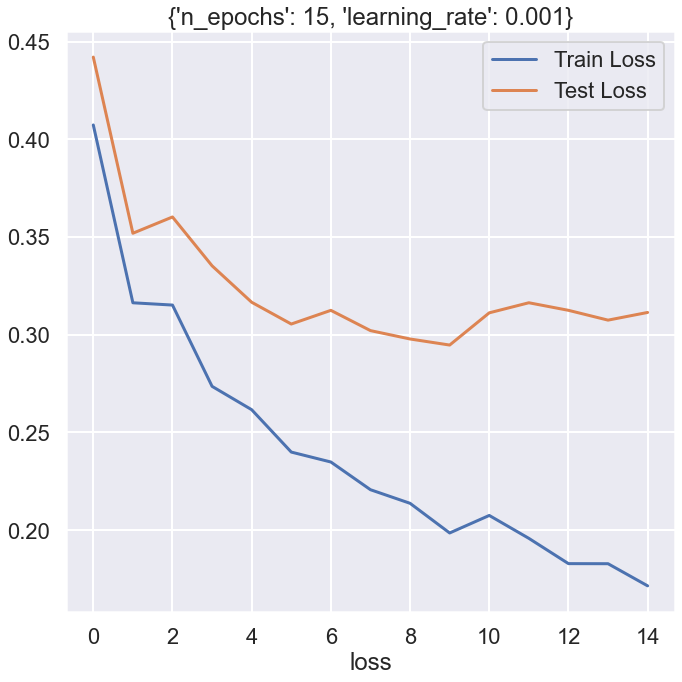

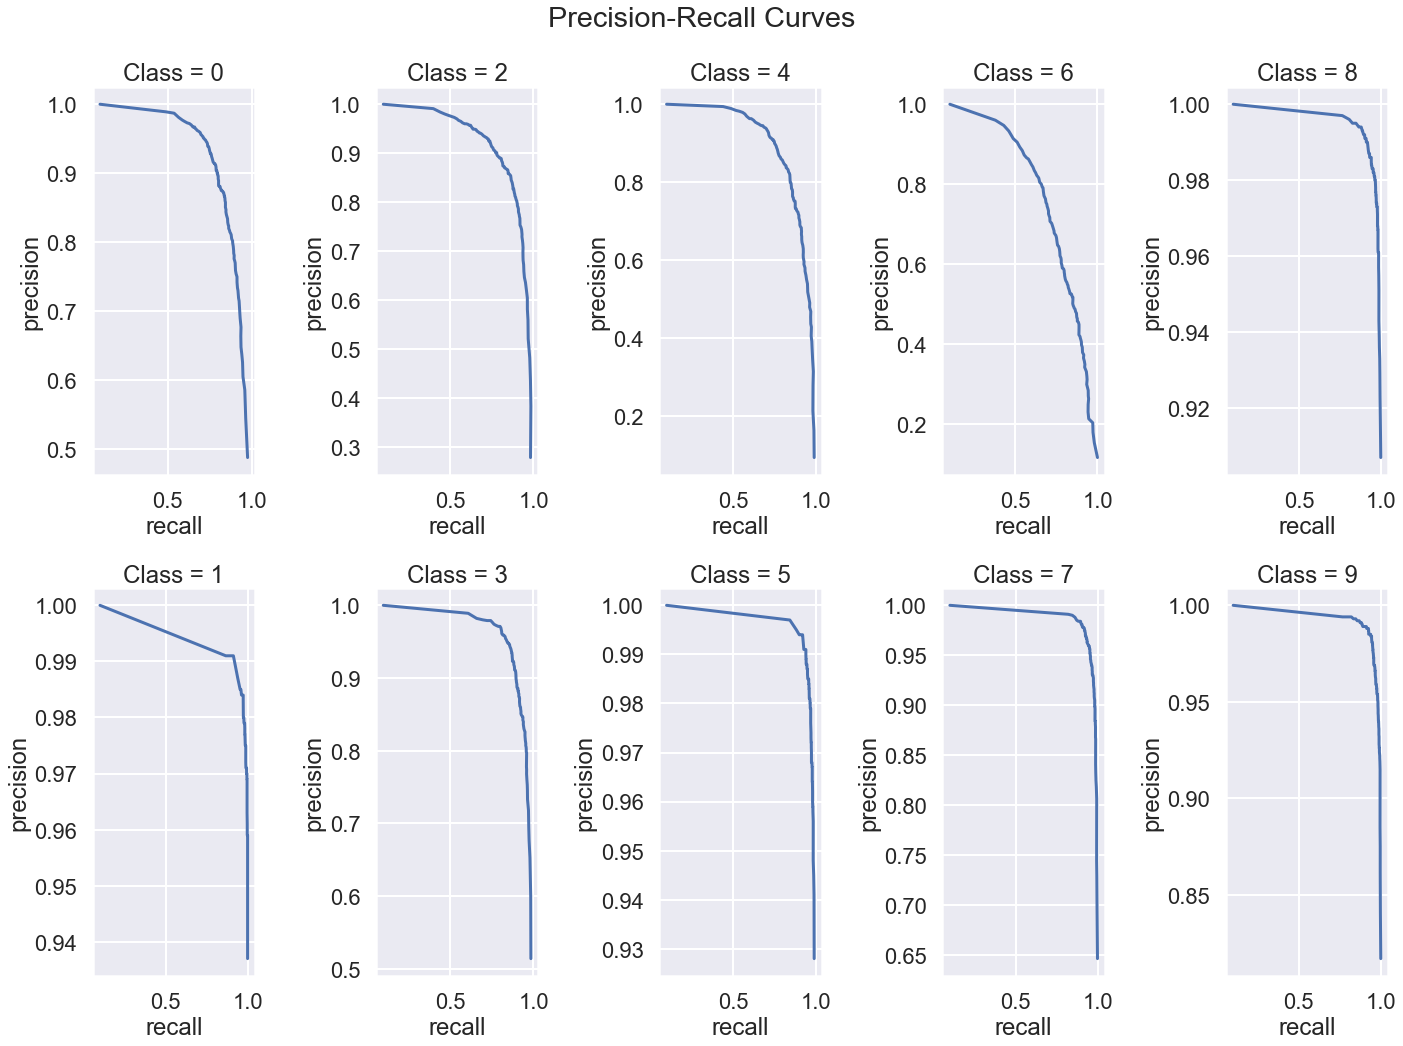

In [21]:
model_cfg = {'n_epochs': 15, 'learning_rate': 0.001}
model, loss_hist = train_test_model(model_cfg, plot_=True, model_arch='Cnn', verbose=2)

# obtenemos la probabilidad de las predicciones en un tensor de: test_size x num_classes
test_probs, test_label = calc_probs(testloader, model)

# graficamos todas las curvas de precisión-recall
plot_pr_curves(len(classes), test_probs, test_label)

Se puede comprobar que las redes neuronales completamente conectadas son capaces de extraer patrones en
imagenes para después hacer una clasificación. A pesar de que la cnn es mejor que la red densa, los
resultados en la clasificación son bastante aceptables.
